# DeepGL - Deep Feature Learning for graphs

We've implemented the [DeepGL](https://arxiv.org/abs/1704.08829) algorithm as a Neo4j procedure and this notebook shows our experiments with it against a SNAP email dataset.

First up let's import some things...

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import pandas as pd
from neo4j.v1 import GraphDatabase
import tensorflow as tf


# load data
from sklearn.preprocessing import StandardScaler

In [45]:
driver = GraphDatabase.driver("bolt://localhost", auth=("neo4j", "neo"))

Time to load our data into Neo4j.

In [17]:
edge_list_file = "https://github.com/meltzerpete/Embedding-Vis/raw/master/emails/emails.edgelist"
labels_file = "https://github.com/meltzerpete/Embedding-Vis/raw/master/emails/emails.labels"
attributes_file = None

with driver.session() as session:
    session.run("CREATE INDEX ON :Beer(beerID)")
    session.run("CREATE INDEX ON :Beerer(beererID)")
    session.run("CREATE INDEX ON :Brewery(breweryID)")
    session.run("CREATE INDEX ON :Geocode(geocodeID)")
    
    result = session.run("""\
        LOAD CSV WITH HEADERS FROM 'https://github.com/aicfr/neo4j-openbeerdb/raw/master/beers.csv' AS row
        MERGE (b:Beer { beerID: toInteger(row.id) })
        SET b.beerName = row.name, b.description = row.descript, b.abv = toFloat(row.abv), b.label = toInteger(row.cat_id)
        """)    
    print(result.summary().counters)
    
    result = session.run("""\
    LOAD CSV WITH HEADERS FROM 'https://github.com/aicfr/neo4j-openbeerdb/raw/master/breweries.csv' AS row
    MERGE (b:Brewery { breweryID: toInteger(row.id) })
    SET b.breweryName = row.name, 
        b.address1 = row.address1, 
        b.city = row.city, 
        b.state = row.state, 
        b.zipCode = row.code, 
        b.country = row.country, 
        b.phoneNumber = row.phone, 
        b.website = row.website, 
        b.description = row.descript
    """)
    print(result.summary().counters)
    
    result = session.run("""\
    USING PERIODIC COMMIT
    LOAD CSV WITH HEADERS FROM "https://github.com/aicfr/neo4j-openbeerdb/raw/master/beers.csv" AS row
    MATCH (beer:Beer {beerID: toInteger(row.id)})
    MATCH (brewery:Brewery {breweryID: toInteger(row.brewery_id)})
    MERGE (beer)-[:BREWED_AT]->(brewery);""")
    print(result.summary().counters)
    
    result = session.run("""\
    LOAD CSV WITH HEADERS FROM 'https://github.com/aicfr/neo4j-openbeerdb/raw/master/styles.csv' AS row
    MERGE (s:Style { styleID: toInteger(row.id) })
    SET s.styleName = row.style_name""")
    print(result.summary().counters)
    
    result = session.run("""\
    USING PERIODIC COMMIT
    LOAD CSV WITH HEADERS FROM "https://github.com/aicfr/neo4j-openbeerdb/raw/master/beers.csv" AS row
    MATCH (beer:Beer {beerID: toInteger(row.id)})
    MATCH (style:Style {styleID: toInteger(row.style_id)})
    MERGE (beer)-[:BEER_STYLE]->(style)""")
    print(result.summary().counters)
    
    result = session.run("""\
    LOAD CSV WITH HEADERS FROM 'https://github.com/aicfr/neo4j-openbeerdb/raw/master/geocodes.csv' AS row
    MERGE (g:Geocode { geocodeID: toInteger(row.id) })
    SET g.latitude = toFloat(row.latitude), g.longitude = toFloat(row.longitude)""")
    print(result.summary().counters)
    
    result = session.run("""\
    USING PERIODIC COMMIT
    LOAD CSV WITH HEADERS FROM "https://github.com/aicfr/neo4j-openbeerdb/raw/master/geocodes.csv" AS row
    MATCH (brewery:Brewery {breweryID: toInteger(row.brewery_id)})
    MATCH (geocode:Geocode {geocodeID: toInteger(row.id)})
    MERGE (brewery)-[:GEOLOCATED_AT]->(geocode)""")
    print(result.summary().counters)

{'properties_set': 23604}
{'properties_set': 12726}
{}
{'properties_set': 141}
{}
{'properties_set': 2608}
{'relationships_created': 1298}


In [35]:
embedding_property_name = "embedding-beers"
node_features = []
pruning_lambda = 0.6
diffusions = 3
iterations = 1

In [ ]:
with driver.session() as session:
    params = {
        "writeProperty": embedding_property_name,
        "nodeFeatures": node_features,
        "pruningLambda": pruning_lambda,
        "diffusions": diffusions,
        "iterations": iterations
    }
    result = session.run("""
    call
    algo.deepgl(
        null,
        null,
        
        {nodeFeatures: $nodeFeatures,
         pruningLambda: $pruningLambda,
         diffusions: $diffusions,
         iterations: $iterations,
         writeProperty: $writeProperty})
    """, params)
    print(result.peek())

In [85]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n) 
    WITH n.label as class, count(*) AS c
    ORDER BY c DESC
    WITH class WHERE c > 50
    WITH class ORDER BY class
    with collect(class) AS biggestClasses
    MATCH (p:Node) WHERE p.label IN biggestClasses
    RETURN p.`%s` AS embedding, apoc.coll.indexOf(biggestClasses, p.label) AS label, p.label as initialLabel
    ORDER BY label
    """ % embedding_property_name)

    df = pd.DataFrame(dict(row) for row in result)

emb = df["embedding"].apply(pd.Series).values
labels = df["label"].values

/Users/markneedham/projects/Embedding-Vis/a/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


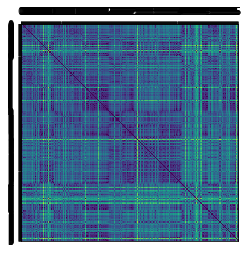

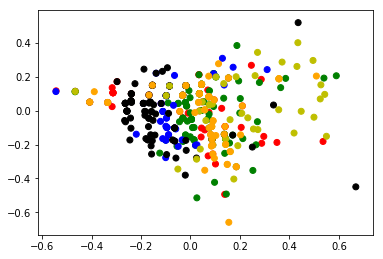

In [7]:
# Heatmap
colours = ['r', 'g', 'b', 'black', 'y', 'orange']
cols = pd.DataFrame(labels).apply(lambda x: colours[int(x)], axis=1).values

dist = np.ndarray([len(emb), len(emb)])

for i, e1 in enumerate(emb):
    for j, e2 in enumerate(emb):
        dist.itemset((i, j), np.linalg.norm(e1 - e2, 2))

plt.imshow(dist)
plt.axes().xaxis.tick_top()
plt.xticks(np.arange(len(dist)), labels)
plt.yticks(np.arange(len(dist)), labels)
plt.show()

# 2D Visualisation
# from: https://baoilleach.blogspot.com/2014/01/convert-distance-matrix-to-2d.html
adist = dist
amax = np.amax(adist)
adist /= amax

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

coords = results.embedding_

plt.subplots_adjust(bottom=0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker='o', c=cols
)

plt.show()

In [86]:
X = pd.DataFrame(emb)
y = labels

X = StandardScaler().fit_transform(X)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=.4, random_state=42)

clf = MLPClassifier(solver='sgd',
                    activation='tanh',
                    learning_rate_init=0.001,
                    alpha=1e-5,
                    hidden_layer_sizes=(30, 30),
                    max_iter=10000,
                    batch_size=X.shape[0],
                    random_state=0)

clf.n_outputs_ = 6
clf.out_activation_ = "softmax"
print(clf.get_params())
clf.fit(train_x, train_y)

mean_acc = clf.score(test_x, test_y)
print(mean_acc)

{'activation': 'tanh', 'alpha': 1e-05, 'batch_size': 433, 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (30, 30), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 0, 'shuffle': True, 'solver': 'sgd', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


/Users/markneedham/projects/Embedding-Vis/a/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:358: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


0.40229885057471265


In [67]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset


def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features = dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset

def evaluate(emb, labels):
    data = pd.DataFrame(emb)
    data.columns = [str(col) for col in data.columns.get_values()]
    
    s_data = StandardScaler().fit_transform(data)
    s_data = pd.DataFrame(s_data)
    s_data.columns = [str(col) for col in s_data.columns.get_values()]    
    s_data["label"] = labels

    train_index = int(len(s_data) * 0.6)
    train = s_data[:train_index]
    test = s_data[train_index:]

    train_x = train.drop("label", axis=1)
    train_y = train["label"]

    test_x = test.drop("label", axis=1)
    test_y = test["label"]

    # Feature columns describe how to use the input.
    my_feature_columns = []
    for key in train_x.keys():
        my_feature_columns.append(tf.feature_column.numeric_column(key=key))
                
    classifier = tf.estimator.DNNClassifier(        
        feature_columns=my_feature_columns,
        # Two hidden layers of 10 nodes each.
        hidden_units=[30, 30],
        # optimizer=
#         activation_fn=tf.nn.tanh,
#         optimizer=tf.train.AdamOptimizer(1e-4),
        # The model must choose between 3 classes.
        n_classes=s_data["label"].unique().size)

    # Train the Model.
    classifier.train(
        input_fn=lambda: train_input_fn(train_x, train_y, data.shape[0]),
        steps=1000)

    # Evaluate the model.
    eval_result = classifier.evaluate(
        input_fn=lambda: eval_input_fn(test_x, test_y, data.shape[0]))

    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

In [68]:
evaluate(emb, labels)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpoixq5ls3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1113feb38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpoixq5ls3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1113feb38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 1 into /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpoixq5ls3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1 into /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpoixq5ls3/model.ckpt.


INFO:tensorflow:loss = 740.1534, step = 1


INFO:tensorflow:loss = 740.1534, step = 1


INFO:tensorflow:global_step/sec: 135.988


INFO:tensorflow:global_step/sec: 135.988


INFO:tensorflow:loss = 38.58873, step = 101 (0.737 sec)


INFO:tensorflow:loss = 38.58873, step = 101 (0.737 sec)


INFO:tensorflow:global_step/sec: 154.588


INFO:tensorflow:global_step/sec: 154.588


INFO:tensorflow:loss = 20.100264, step = 201 (0.647 sec)


INFO:tensorflow:loss = 20.100264, step = 201 (0.647 sec)


INFO:tensorflow:global_step/sec: 154.402


INFO:tensorflow:global_step/sec: 154.402


INFO:tensorflow:loss = 17.333557, step = 301 (0.648 sec)


INFO:tensorflow:loss = 17.333557, step = 301 (0.648 sec)


INFO:tensorflow:global_step/sec: 162.907


INFO:tensorflow:global_step/sec: 162.907


INFO:tensorflow:loss = 16.242493, step = 401 (0.614 sec)


INFO:tensorflow:loss = 16.242493, step = 401 (0.614 sec)


INFO:tensorflow:global_step/sec: 152.807


INFO:tensorflow:global_step/sec: 152.807


INFO:tensorflow:loss = 13.206288, step = 501 (0.654 sec)


INFO:tensorflow:loss = 13.206288, step = 501 (0.654 sec)


INFO:tensorflow:global_step/sec: 154.671


INFO:tensorflow:global_step/sec: 154.671


INFO:tensorflow:loss = 10.628039, step = 601 (0.647 sec)


INFO:tensorflow:loss = 10.628039, step = 601 (0.647 sec)


INFO:tensorflow:global_step/sec: 152.925


INFO:tensorflow:global_step/sec: 152.925


INFO:tensorflow:loss = 11.851509, step = 701 (0.654 sec)


INFO:tensorflow:loss = 11.851509, step = 701 (0.654 sec)


INFO:tensorflow:global_step/sec: 155.48


INFO:tensorflow:global_step/sec: 155.48


INFO:tensorflow:loss = 11.318499, step = 801 (0.643 sec)


INFO:tensorflow:loss = 11.318499, step = 801 (0.643 sec)


INFO:tensorflow:global_step/sec: 157.278


INFO:tensorflow:global_step/sec: 157.278


INFO:tensorflow:loss = 11.050767, step = 901 (0.635 sec)


INFO:tensorflow:loss = 11.050767, step = 901 (0.635 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpoixq5ls3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpoixq5ls3/model.ckpt.


INFO:tensorflow:Loss for final step: 11.324417.


INFO:tensorflow:Loss for final step: 11.324417.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2018-07-02-10:15:48


INFO:tensorflow:Starting evaluation at 2018-07-02-10:15:48


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpoixq5ls3/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpoixq5ls3/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2018-07-02-10:15:48


INFO:tensorflow:Finished evaluation at 2018-07-02-10:15:48


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.22413793, average_loss = 13.924838, global_step = 1000, loss = 2422.9219


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.22413793, average_loss = 13.924838, global_step = 1000, loss = 2422.9219



Test set accuracy: 0.224

